In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix , classification_report, f1_score, accuracy_score, precision_score, recall_score, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('stopwords')
import re
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
df = pd.read_csv(r"C:\Users\Pc\Desktop\PFA\WELFake_Dataset.csv")


In [12]:
df.head(10)

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1
6,6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,1
7,7,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,1
8,8,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",1
9,9,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",1


In [13]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [14]:
df.describe()

,label
count,72134.000000
mean,0.514404
std,0.499796
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [16]:
df.shape

(72134, 3)

In [17]:
df.dtypes

title    object
text     object
label     int64
dtype: object

In [18]:
df.isna().sum()

title    558
text      39
label      0
dtype: int64

In [19]:
df = df.dropna(subset=['text'])
df = df.dropna(subset=['title'])

In [20]:
df.isna().sum()

title    0
text     0
label    0
dtype: int64

In [21]:
df.describe(include = 'object')

,title,text
count,71537,71537
unique,62308,62200
top,Factbox: Trump fills top jobs for his administ...,
freq,14,738


In [22]:
df['title'].nunique()

62308

In [23]:
df['text'].nunique()

62200

In [24]:
print(df['label'].value_counts())

label
1    36509
0    35028
Name: count, dtype: int64


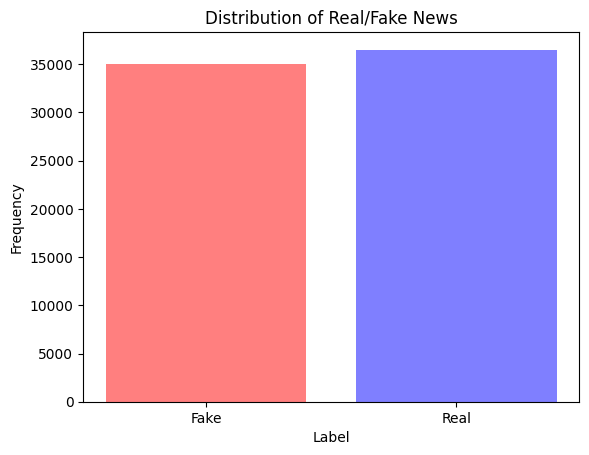

In [25]:
fake_count = df[df['label'] == 0]['label'].count()
real_count = df[df['label'] == 1]['label'].count()

plt.bar(['Fake', 'Real'], [fake_count, real_count], color=['red', 'blue'], alpha=0.5)

plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Distribution of Real/Fake News')

plt.show()


In [26]:
df['text'] = df['text'].astype(str)

In [27]:
df["title_text"] = df["title"] + df["text"]
df.head()

,title,text,label,title_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,About Time! Christian Group Sues Amazon and SP...


In [28]:
df["body_length"] = df["title_text"].apply(lambda x: len(x) - x.count(" "))
df["title_length"] = df["title"].apply(lambda x: len(x) - x.count(" "))
df["text_length"] = df["text"].apply(lambda x: len(x) - x.count(" "))
df.head()

,title,text,label,title_text,body_length,title_length,text_length
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,4222,113,4109
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,299,120,179
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",6811,90,6721
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,1668,80,1588
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,About Time! Christian Group Sues Amazon and SP...,1342,66,1276


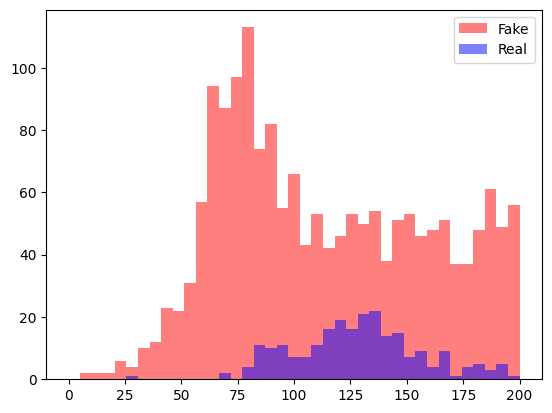

In [29]:
bins = np.linspace(0, 200, 40)

plt.hist(df[df["label"]== 1]["body_length"], bins, alpha=0.5, label="Fake", color="RED")
plt.hist(df[df["label"]== 0]["body_length"], bins, alpha=0.5, label="Real", color="BLUE")

plt.legend()

plt.show()

Les Fake News ont généralement un nombre de mots supérieur à celui dans les Real News

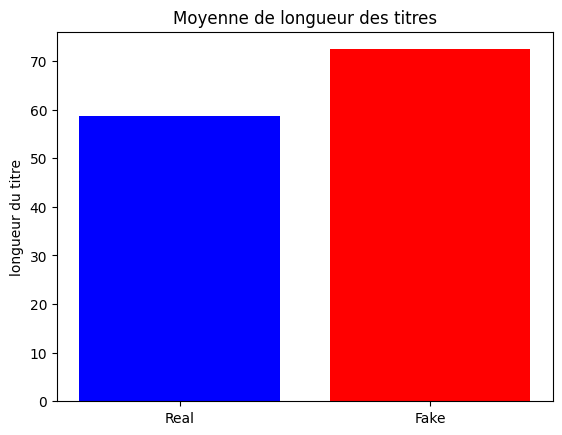

In [30]:
means = df.groupby('label')['title_length'].mean()


plt.bar(means.index, means.values, color=['blue', 'red'])
plt.xticks(means.index, ['Real', 'Fake'])
plt.ylabel('longueur du titre')
plt.title('Moyenne de longueur des titres')
plt.show()

In [31]:
x = df.drop('label', axis=1)
y = df['label']

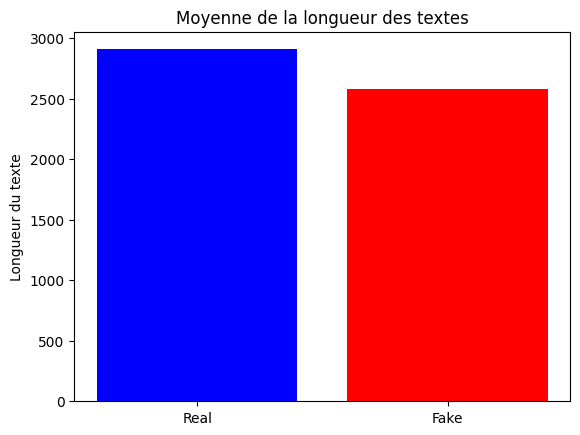

In [32]:
means = df.groupby('label')['text_length'].mean()


plt.bar(means.index, means.values, color=['blue', 'red'])
plt.xticks(means.index, ['Real', 'Fake'])
plt.ylabel('Longueur du texte')
plt.title('Moyenne de la longueur des textes')
plt.show()

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71537 entries, 0 to 72133
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         71537 non-null  object
 1   text          71537 non-null  object
 2   label         71537 non-null  int64 
 3   title_text    71537 non-null  object
 4   body_length   71537 non-null  int64 
 5   title_length  71537 non-null  int64 
 6   text_length   71537 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 4.4+ MB


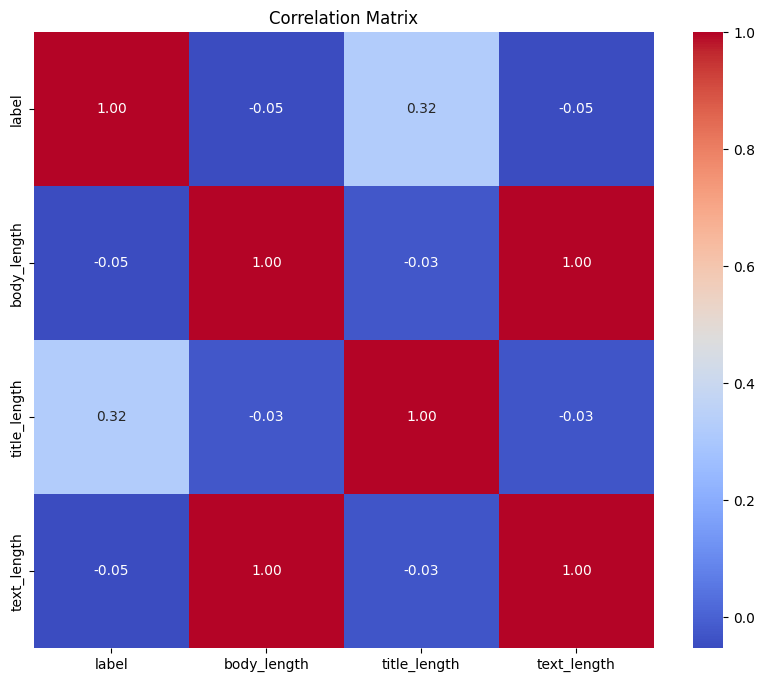

In [34]:
numeric = df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [35]:
x = df.drop('label', axis=1)
y = df['label']

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [37]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50075, 6)
(50075,)
(21462, 6)
(21462,)


In [38]:
pd.DataFrame(x_train).describe()

,body_length,title_length,text_length
count,50075.000000,50075.000000,50075.000000
mean,2809.373899,65.852941,2743.520959
std,3061.093368,21.336156,3061.783387
min,10.000000,3.000000,0.000000
25%,1230.000000,53.000000,1162.000000
50%,2100.000000,62.000000,2034.000000
75%,3468.000000,75.000000,3404.500000
max,122556.000000,385.000000,122490.000000


# TFIDF 

In [39]:
tfidf_title = TfidfVectorizer()
tfidf_text = TfidfVectorizer()

In [40]:
tfidf_title.fit(x_train['title'])
tfidf_text.fit(x_train['text'])

TfidfVectorizer()

In [41]:
x_train_title_tfidf = tfidf_title.transform(x_train['title'])
x_train_text_tfidf = tfidf_text.transform(x_train['text'])
x_test_title_tfidf = tfidf_title.transform(x_test['title'])
x_test_text_tfidf = tfidf_text.transform(x_test['text'])

# Machine Learning algorithms

# NB

In [42]:
nb_classifier_title = MultinomialNB()
nb_classifier_text = MultinomialNB()

In [43]:
nb_classifier_title.fit(x_train_title_tfidf, y_train)
nb_classifier_text.fit(x_train_text_tfidf, y_train)

MultinomialNB()

In [44]:
y_pred_title = nb_classifier_title.predict(x_test_title_tfidf)
y_pred_text = nb_classifier_text.predict(x_test_text_tfidf)

In [45]:
print("Rapport de classification pour les prédictions du titre :")
print(classification_report(y_test, y_pred_title))

Rapport de classification pour les prédictions du titre :
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     10595
           1       0.87      0.90      0.89     10867

    accuracy                           0.88     21462
   macro avg       0.88      0.88      0.88     21462
weighted avg       0.88      0.88      0.88     21462



In [46]:
print("Rapport de classification pour les prédictions du texte :")
print(classification_report(y_test, y_pred_text))

Rapport de classification pour les prédictions du texte :
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     10595
           1       0.86      0.87      0.87     10867

    accuracy                           0.87     21462
   macro avg       0.87      0.87      0.87     21462
weighted avg       0.87      0.87      0.87     21462



In [47]:
# Méthode de la majorité des votes
y_pred_majority = [max(set(predictions), key=predictions.count) for predictions in zip(y_pred_title, y_pred_text)]

In [48]:
print(classification_report(y_test, y_pred_majority))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88     10595
           1       0.93      0.82      0.87     10867

    accuracy                           0.88     21462
   macro avg       0.88      0.88      0.88     21462
weighted avg       0.88      0.88      0.88     21462



In [49]:
# Méthode de la confiance moyenne
y_pred_proba_title = nb_classifier_title.predict_proba(x_test_title_tfidf)
y_pred_proba_text = nb_classifier_text.predict_proba(x_test_text_tfidf)
y_pred_avg_confidence = [(proba_title + proba_text) / 2 for proba_title, proba_text in zip(y_pred_proba_title, y_pred_proba_text)]
y_pred_average_confidence = [np.argmax(confidence) for confidence in y_pred_avg_confidence]

In [50]:
print(classification_report(y_test, y_pred_average_confidence))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89     10595
           1       0.89      0.91      0.90     10867

    accuracy                           0.90     21462
   macro avg       0.90      0.90      0.90     21462
weighted avg       0.90      0.90      0.90     21462



# Decision Tree 

In [51]:
dt_classifier_title = DecisionTreeClassifier(max_depth=5, criterion='gini', random_state=42)
dt_classifier_text = DecisionTreeClassifier(max_depth=5, criterion='gini', random_state=42)

In [52]:
dt_classifier_title.fit(x_train_title_tfidf, y_train)
dt_classifier_text.fit(x_train_text_tfidf, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [53]:
y_pred_title = dt_classifier_title.predict(x_test_title_tfidf)
y_pred_text = dt_classifier_text.predict(x_test_text_tfidf)

In [54]:
print("Rapport de classification pour les prédictions du titre :")
print(classification_report(y_test, y_pred_title))

Rapport de classification pour les prédictions du titre :
              precision    recall  f1-score   support

           0       0.65      0.95      0.77     10595
           1       0.91      0.49      0.64     10867

    accuracy                           0.72     21462
   macro avg       0.78      0.72      0.70     21462
weighted avg       0.78      0.72      0.70     21462



In [55]:
print("Rapport de classification pour les prédictions du texte :")
print(classification_report(y_test, y_pred_text))

Rapport de classification pour les prédictions du texte :
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     10595
           1       0.88      0.90      0.89     10867

    accuracy                           0.89     21462
   macro avg       0.89      0.88      0.89     21462
weighted avg       0.89      0.89      0.89     21462



In [56]:
# Combinaison des prédictions en utilisant la méthode de la majorité des votes
y_pred_majority = [max(set(predictions), key=predictions.count) for predictions in zip(y_pred_title, y_pred_text)]

In [57]:
print(classification_report(y_test, y_pred_majority))

              precision    recall  f1-score   support

           0       0.63      0.98      0.77     10595
           1       0.96      0.45      0.61     10867

    accuracy                           0.71     21462
   macro avg       0.80      0.71      0.69     21462
weighted avg       0.80      0.71      0.69     21462



In [58]:
y_pred_proba_title = dt_classifier_title.predict_proba(x_test_title_tfidf)
y_pred_proba_text = dt_classifier_text.predict_proba(x_test_text_tfidf)

# Calculer la confiance moyenne en moyennant les probabilités prédites pour chaque classe
y_pred_avg_confidence = [(proba_title + proba_text) / 2 for proba_title, proba_text in zip(y_pred_proba_title, y_pred_proba_text)]

# Convertir les confiances moyennes en prédictions de classe en choisissant la classe avec la plus haute confiance
y_pred_average_confidence = [np.argmax(confidence) for confidence in y_pred_avg_confidence]

In [59]:
print("Rapport de classification pour les prédictions combinées (Méthode de la confiance moyenne) :")
print(classification_report(y_test, y_pred_average_confidence))

Rapport de classification pour les prédictions combinées (Méthode de la confiance moyenne) :
              precision    recall  f1-score   support

           0       0.93      0.90      0.91     10595
           1       0.90      0.93      0.92     10867

    accuracy                           0.92     21462
   macro avg       0.92      0.92      0.92     21462
weighted avg       0.92      0.92      0.92     21462



# Random Forest

In [60]:
rf_classifier_title = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_text = RandomForestClassifier(n_estimators=100, random_state=42)

In [61]:
rf_classifier_title.fit(x_train_title_tfidf, y_train)
rf_classifier_text.fit(x_train_text_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [62]:
y_pred_title = rf_classifier_title.predict(x_test_title_tfidf)
y_pred_text = rf_classifier_text.predict(x_test_text_tfidf)

In [63]:
print("Rapport de classification pour les prédictions du titre :")
print(classification_report(y_test, y_pred_title))

Rapport de classification pour les prédictions du titre :
              precision    recall  f1-score   support

           0       0.91      0.90      0.91     10595
           1       0.91      0.92      0.91     10867

    accuracy                           0.91     21462
   macro avg       0.91      0.91      0.91     21462
weighted avg       0.91      0.91      0.91     21462



In [64]:
print("Rapport de classification pour les prédictions du texte :")
print(classification_report(y_test, y_pred_text))

Rapport de classification pour les prédictions du texte :
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     10595
           1       0.91      0.95      0.93     10867

    accuracy                           0.93     21462
   macro avg       0.93      0.93      0.93     21462
weighted avg       0.93      0.93      0.93     21462



In [65]:
#la méthode de la confiance moyenne
y_pred_proba_title = rf_classifier_title.predict_proba(x_test_title_tfidf)
y_pred_proba_text = rf_classifier_text.predict_proba(x_test_text_tfidf)
y_pred_avg_confidence = [(proba_title + proba_text) / 2 for proba_title, proba_text in zip(y_pred_proba_title, y_pred_proba_text)]
y_pred_average_confidence = [np.argmax(confidence) for confidence in y_pred_avg_confidence]

In [66]:
print("Rapport de classification pour les prédictions combinées (Méthode de la confiance moyenne) :")
print(classification_report(y_test, y_pred_average_confidence))

Rapport de classification pour les prédictions combinées (Méthode de la confiance moyenne) :
              precision    recall  f1-score   support

           0       0.96      0.93      0.94     10595
           1       0.94      0.96      0.95     10867

    accuracy                           0.95     21462
   macro avg       0.95      0.95      0.95     21462
weighted avg       0.95      0.95      0.95     21462



In [67]:
#la méthode de la majorité des votes
y_pred_majority = [max(set(predictions), key=predictions.count) for predictions in zip(y_pred_title, y_pred_text)]

In [68]:
print("Rapport de classification pour les prédictions combinées (Méthode de la majorité des votes) :")
print(classification_report(y_test, y_pred_majority))

Rapport de classification pour les prédictions combinées (Méthode de la majorité des votes) :
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     10595
           1       0.97      0.88      0.92     10867

    accuracy                           0.92     21462
   macro avg       0.93      0.93      0.92     21462
weighted avg       0.93      0.92      0.92     21462



# DEEP LEARNING ALGORITHMS

# Bert

In [3]:
port = PorterStemmer()

def stemming(text):
    stem_text = re.sub('[^a-zA-Z]', ' ', text)
    stem_text = stem_text.lower()
    stem_text = stem_text.split()
    
    stem_text = [port.stem(word) for word in stem_text if not word in stopwords.words('english')]
    stem_text = ' '.join(stem_text)
    
    return stem_text

In [167]:
def refinement_tfidf(text): # TF-IDF
    ex = text.split('.')
    ex = pd.DataFrame(ex)[0].apply(stemming)
    
    if ex[0] == '':
        return text
    
    vectorizer = TfidfVectorizer()
    try:
        vectorizer.fit(ex)
        features = vectorizer.transform(ex)
    except:
        return text
    
    feature_names = np.array(vectorizer.get_feature_names_out())
    feature_count = features.toarray().mean(axis=0)
    
    refined_text = ' '.join(feature_names[feature_count > 0.05]) 
    
    return refined_text

In [176]:
df['refined_tfidf'] = df['text'].apply(refinement_tfidf)

In [177]:
df.head()

,title,text,label,title_text,body_length,title_length,text_length,refined_tfidf
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,4222,113,4109,said
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,299,120,179,aka chang constitut creat demonstr eric exerci...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",6811,90,6721,jindal
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,1668,80,1588,design dub km mile missil rs sarmat satan weapon
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,About Time! Christian Group Sues Amazon and SP...,1342,66,1276,amazon center djkm free group guidestar hate l...


In [178]:
labels = df['label'].values
texts = (df['title'] + ' ' + df['refined_tfidf']).values

In [179]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [180]:
idx = np.random.choice(range(len(texts)))
print(texts[idx])
# Tokenized
print(tokenizer.tokenize(texts[idx]))
# Token to Integral
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[idx])))

Factbox: What is in Obama's final budget proposal? ask billion fund obama propos
['fact', '##box', ':', 'what', 'is', 'in', 'obama', "'", 's', 'final', 'budget', 'proposal', '?', 'ask', 'billion', 'fund', 'obama', 'prop', '##os']
[2755, 8758, 1024, 2054, 2003, 1999, 8112, 1005, 1055, 2345, 5166, 6378, 1029, 3198, 4551, 4636, 8112, 17678, 2891]


In [181]:
max_len = 0
id_len = []
for text in texts:
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    if len(input_ids) > 200:
        continue
    id_len.append(len(input_ids))
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (945 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  197


In [183]:
def tokenize_map(sentence, labs='None'):
    global labels
    input_ids = []
    attention_masks = []
    for text in sentence:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens = True, # [CLS] & [SEP]
                            truncation = 'longest_first', # Control truncation
                            max_length = 100, # Max length about texts
                            pad_to_max_length = True, # Pad and truncate about sentences
                            return_attention_mask = True, # Attention masks
                            return_tensors = 'pt') # Return to pytorch tensors
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if labs != 'None':
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [184]:
input_ids, attention_masks, labels = tokenize_map(texts, labels)

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
len(train_dataset.indices), len(val_dataset.indices)

C:\Users\Pc\anaconda3\envs\cuda_test\lib\site-packages\transformers\tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
C:\Users\Pc\AppData\Local\Temp\ipykernel_7996\4287229203.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labs != 'None':


(57229, 14308)

In [185]:
batch_size = 32
num_workers = 4

train_loader = DataLoader(
                dataset=train_dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=num_workers)

val_loader = DataLoader(
                dataset=val_dataset,
                batch_size=1,
                shuffle=False)

In [186]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [187]:
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=6e-6,
                              eps=1e-8)

In [188]:
num_epochs = 10
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [191]:
import os

# Create the directory if it does not exist
if not os.path.exists('nets'):
    os.makedirs('nets')

model.train()
total_step = len(train_loader)
for epoch in range(num_epochs):
    total_loss = 0
    for i, (ids, masks, labels) in enumerate(train_loader):
        ids = ids.to(device)
        masks = masks.to(device)
        labels = labels.to(device)
        
        loss = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)[0]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        if (i+1) % 100 == 0:
            print('{} / {}'.format(batch_size*(i+1), train_dataset.__len__()))
            
    print('Epoch: {}, Loss: {:.4f}'.format(epoch+1, total_loss / total_step))
            
torch.save(model.state_dict(), 'nets/BERT.ckpt')


3200 / 57229
6400 / 57229
9600 / 57229
12800 / 57229
16000 / 57229
19200 / 57229
22400 / 57229
25600 / 57229
28800 / 57229
32000 / 57229
35200 / 57229
38400 / 57229
41600 / 57229
44800 / 57229
48000 / 57229
51200 / 57229
54400 / 57229
Epoch: 1, Loss: 0.0061
3200 / 57229
6400 / 57229
9600 / 57229
12800 / 57229
16000 / 57229
19200 / 57229
22400 / 57229
25600 / 57229
28800 / 57229
32000 / 57229
35200 / 57229
38400 / 57229
41600 / 57229
44800 / 57229
48000 / 57229
51200 / 57229
54400 / 57229
Epoch: 2, Loss: 0.0074
3200 / 57229
6400 / 57229
9600 / 57229
12800 / 57229
16000 / 57229
19200 / 57229
22400 / 57229
25600 / 57229
28800 / 57229
32000 / 57229
35200 / 57229
38400 / 57229
41600 / 57229
44800 / 57229
48000 / 57229
51200 / 57229
54400 / 57229
Epoch: 3, Loss: 0.0069
3200 / 57229
6400 / 57229
9600 / 57229
12800 / 57229
16000 / 57229
19200 / 57229
22400 / 57229
25600 / 57229
28800 / 57229
32000 / 57229
35200 / 57229
38400 / 57229
41600 / 57229
44800 / 57229
48000 / 57229
51200 / 57229
54400

In [192]:
model.eval()
model.load_state_dict(torch.load('nets/BERT.ckpt', map_location=device))

<All keys matched successfully>

In [193]:
score = 0
for i, (ids, masks, labels) in enumerate(val_loader):
    ids = ids.to(device)
    masks = masks.to(device)
    labels = labels.to(device)

    g_labels = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)[1]
    
    pred = torch.max(g_labels, 1)[1][0].item()
    gt = labels[0].item()
    
    score += int(pred == gt)

avg = score / len(val_dataset)
print('Accuracy: {:.4f}\n'.format(avg))

Accuracy: 0.9635



# RNN, LSTM ET CNN

In [282]:
df['combined_text'] = df['title'] + " " + df['text']  # Concatenate title and text
texts = df['combined_text'].astype(str).values
labels = df['label'].values

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.vectorizer = CountVectorizer(max_features=10000)
        self.texts = self.vectorizer.fit_transform(texts).toarray()
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
train_dataset = TextDataset(train_texts, train_labels)
test_dataset = TextDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# RNN

In [287]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.to(device)
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        last_hidden = hidden[-1]
        return self.fc(last_hidden)

In [288]:
vocab_size = len(train_dataset.vectorizer.vocabulary_)
embedding_dim = 100
hidden_dim = 256
output_dim = 2
num_layers = 2

model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

Epoch 1, Loss: 0.701461911201477
Epoch 2, Loss: 0.7010279387785376
Epoch 3, Loss: 0.7014590985219261
Epoch 4, Loss: 0.7031451268793152
Epoch 5, Loss: 0.7035760680279164
Epoch 6, Loss: 0.7033231454631215
Epoch 7, Loss: 0.7018293714043546
Epoch 8, Loss: 0.7039062969840526
Epoch 9, Loss: 0.7022285800595868
Epoch 10, Loss: 0.7035132912432701


In [289]:
def evaluate_model(model, test_loader):
    model.eval()  
    true_labels = []
    predicted_labels = []

    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')
    
    return accuracy, precision, recall, f1

In [290]:
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.5051
Precision: 0.5051
Recall: 1.0000
F1 Score: 0.6712


# LSTM

In [297]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.to(device)  
        embedded = self.embedding(x)  
        output, (hidden, cell) = self.lstm(embedded)  
        hidden = hidden.squeeze(0)  
        return self.fc(hidden)


In [298]:
vocab_size = len(train_dataset.vectorizer.vocabulary_)
embedding_dim = 100
hidden_dim = 256
output_dim = 2
num_layers = 1

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

Epoch 1, Loss: 0.6954186152252423
Epoch 2, Loss: 0.6715141370717609
Epoch 3, Loss: 0.6448962480879283
Epoch 4, Loss: 0.6417668395831373
Epoch 5, Loss: 0.6324099556336261
Epoch 6, Loss: 0.6089480267915731
Epoch 7, Loss: 0.5996017675115917
Epoch 8, Loss: 0.5935087519494298
Epoch 9, Loss: 0.5797659752920662
Epoch 10, Loss: 0.5703749679333008


In [300]:
def evaluate_model(model, test_loader):
    model.eval()  
    true_labels = []
    predicted_labels = []

    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')
    
    return accuracy, precision, recall, f1

In [301]:
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.7016
Precision: 0.7399
Recall: 0.6310
F1 Score: 0.6811


# CNN

In [69]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, output_dim, dropout):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList(
            [nn.Conv2d(1, num_filters, (fs, embedding_dim)) for fs in filter_sizes]
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)

    def forward(self, x):
        x = x.to(device)  
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]  
        x = [F.max_pool1d(line, line.size(2)).squeeze(2) for line in x]  
        x = torch.cat(x, 1) 
        x = self.dropout(x)
        x = self.fc(x) 
        return x

In [ ]:
vocab_size = len(train_dataset.vectorizer.vocabulary_)
embedding_dim = 100
num_filters = 100
filter_sizes = [2, 3, 4] 
output_dim = 2
dropout = 0.5

model = TextCNN(vocab_size, embedding_dim, num_filters, filter_sizes, output_dim, dropout)
model.to(device)

In [305]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

Epoch 1, Loss: 0.6885053938230767
Epoch 2, Loss: 0.6713557857384956
Epoch 3, Loss: 0.6668672254460027
Epoch 4, Loss: 0.6635040737784329
Epoch 5, Loss: 0.6608435180415115
Epoch 6, Loss: 0.6588693765237252
Epoch 7, Loss: 0.6556798372107421
Epoch 8, Loss: 0.6547116966571402
Epoch 9, Loss: 0.6525119980365088
Epoch 10, Loss: 0.651279651648909


In [306]:
def evaluate_model(model, test_loader):
    model.eval()  
    true_labels = []
    predicted_labels = []

    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')
    
    return accuracy, precision, recall, f1

In [307]:
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.5991
Precision: 0.5923
Recall: 0.6618
F1 Score: 0.6251
